In [1]:
import MIMENetEnsemble
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json

In [2]:
#set path to simulation data
simulation_path = "../data/test_simulation"

In [4]:
#set training parameters
training_path = "../data/test_simulation/second_round/"
epochs = 20
learning_rate = 0.00001
batch_size = 2**16
lambda_l2 = 0.00001
hidden_size_factor = 2
bottleneck = 1/2

In [5]:
model, history = MIMENetEnsemble.train(
    training_path=training_path+'parsed_reads.txt',
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    lambda_l2=lambda_l2,
    hidden_size_factor=hidden_size_factor,
    bottleneck=bottleneck,
    kd_path="../data/test_simulation/secondFromProt1/prot1/single_kds.txt",
    model_path=None
)

Device: cuda:0
Number of training examples: 499989


  5%|▌         | 1/20 [00:52<16:35, 52.39s/it]


KeyboardInterrupt: 

In [5]:
#save model
torch.save(model.state_dict(), './ensembleExpCond.pth')

In [6]:
#save training history as json
with open('./history_exp_ens.json', 'w') as f:
    json.dump(history, f)

TypeError: Object of type ndarray is not JSON serializable

In [7]:
#load saved model, training history, and prediction history
input_size = len(open(training_path+'parsed_reads.txt').readline().split('_')[0])
model = MIMENet.MIMENet(input_size, hidden_size_factor, bottleneck, 1)
model.load_state_dict(torch.load('./modelExpCond.pth'))
#puto model to gpu
model.to('cuda:0')
#put model in eval mode
model.eval()
#load history
with open('./history_exp.json', 'r') as f:
    history = json.load(f)

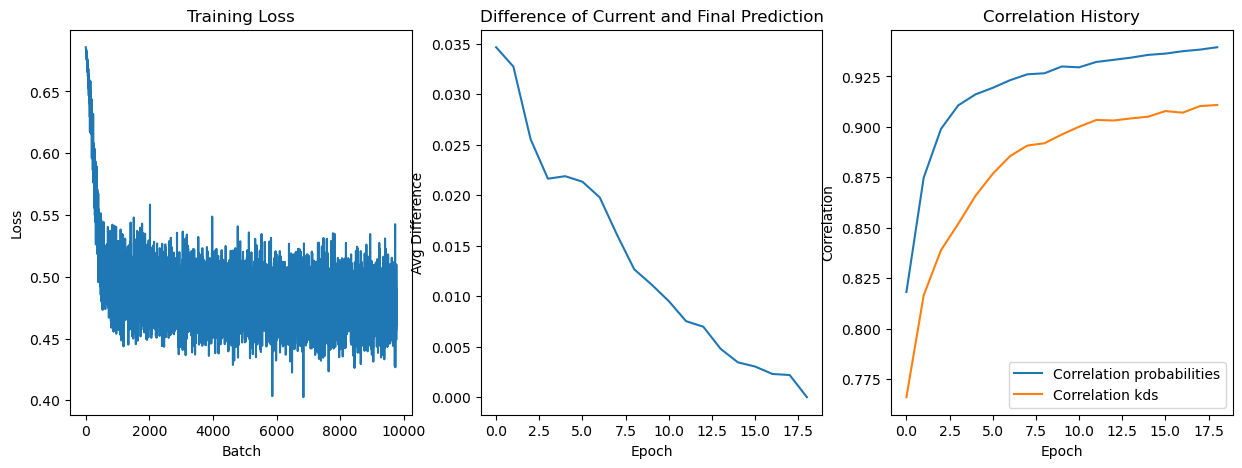

In [7]:
# set up 3 side by side plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

#plot training history
axs[0].plot(history['training'])
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')

#plot difference of current and final prediction

#initialize difference array
predictions = np.array(history['prediction'][1:])
difference = np.zeros((predictions.shape[0], predictions.shape[1]))
#calculate difference
for i in range(predictions.shape[0]):
    difference[i] = np.abs(predictions[i] - predictions[-1])
#average over columns
difference = np.mean(difference, axis=1)
#plot difference
axs[1].plot(difference)
axs[1].set_title('Difference of Current and Final Prediction')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Avg Difference')

#plot correlation history rows as lines
axs[2].plot(history['correlation_probs'][1:], label='Correlation probabilities')
axs[2].plot(history['correlation_kds'][1:], label='Correlation kds')
axs[2].legend()
axs[2].set_title("Correlation History")
axs[2].set_ylabel("Correlation")
axs[2].set_xlabel("Epoch")
plt.show()

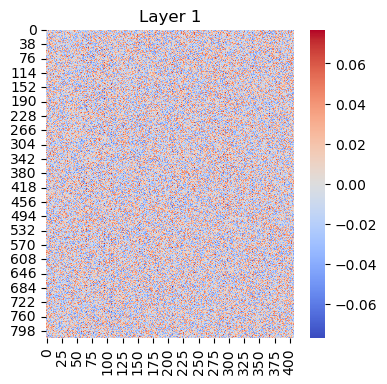

max weight value:  0.076895155
min weight value:  -0.07687693
number of pruned weights:  0
number of non zero weights:  332928
max bias value:  0.05225661
min bias value:  -0.05080943
number of pruned biases:  0
number of non zero biases:  816


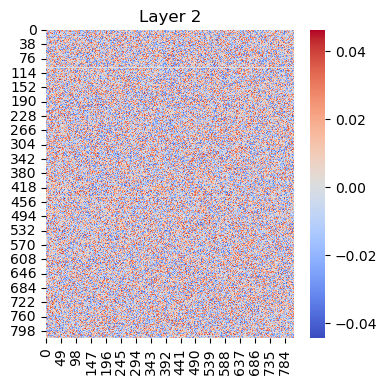

max weight value:  0.046294082
min weight value:  -0.04425745
number of pruned weights:  0
number of non zero weights:  665856
max bias value:  0.03771525
min bias value:  -0.033712048
number of pruned biases:  0
number of non zero biases:  816


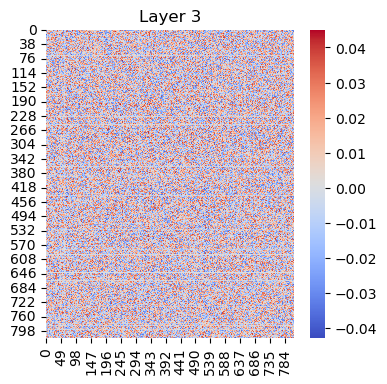

max weight value:  0.045070462
min weight value:  -0.04274043
number of pruned weights:  0
number of non zero weights:  665856
max bias value:  0.038852945
min bias value:  -0.033975538
number of pruned biases:  0
number of non zero biases:  816


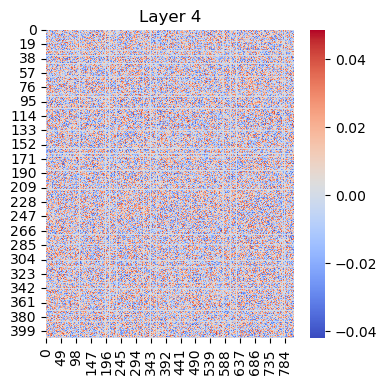

max weight value:  0.048526715
min weight value:  -0.04209219
number of pruned weights:  0
number of non zero weights:  332928
max bias value:  0.03843433
min bias value:  -0.032812096
number of pruned biases:  0
number of non zero biases:  408


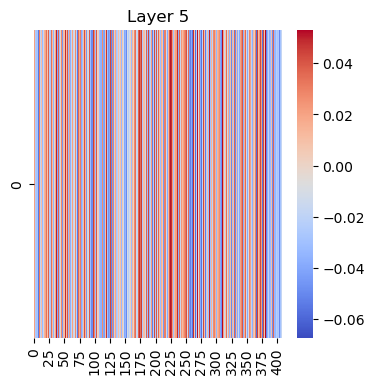

max weight value:  0.05315723
min weight value:  -0.06729593
number of pruned weights:  0
number of non zero weights:  408
max bias value:  0.04050011
min bias value:  0.04050011
number of pruned biases:  0
number of non zero biases:  1


In [8]:
for name, param in model.named_parameters():
    #if weight is not a bias
    if 'bias' not in name:
        #reshape weights to 2d array
        weight = param.data.cpu().numpy().reshape(param.data.cpu().numpy().shape[0], param.data.cpu().numpy().shape[1])
        #plot heatmap of weights
        plt.figure(figsize=(4,4))
        sns.heatmap(weight, cmap='coolwarm')
        # get layer number from name
        layer = [int(s) for s in name if s.isdigit()]
        plt.title(f'Layer {layer[0]}')
        plt.show()

        print('max weight value: ', np.max(weight))
        print('min weight value: ', np.min(weight))
        print('number of pruned weights: ', np.sum(weight == 0))
        print('number of non zero weights: ', np.sum(weight != 0))

    else:
        bias = param.data.cpu().numpy()
 
        print('max bias value: ', np.max(bias))
        print('min bias value: ', np.min(bias))
        print('number of pruned biases: ', np.sum(bias == 0))
        print('number of non zero biases: ', np.sum(bias != 0))

In [9]:
#get percent of parameters pruned
total_params = 0
pruned_params = 0
for param in model.parameters():
    total_params += param.numel()
    pruned_params += np.sum(param.data.cpu().numpy() == 0)
print('percent of parameters pruned: ', pruned_params/total_params)

percent of parameters pruned:  0.0


In [10]:
# read in kd values
single_kd_sim = np.loadtxt(simulation_path+'/secondFromProt1/prot1/single_kds.txt')

#insert 1 at position 0 and then every 3rd position
single_kd_sim = np.insert(single_kd_sim, 0, 1)
single_kd_sim = np.insert(single_kd_sim, np.arange(4, len(single_kd_sim), 3), 1)
single_kd_sim[0:10]

array([1.      , 1.      , 0.845767, 0.275241, 1.      , 1.      ,
       1.      , 1.11722 , 1.      , 1.      ])

In [27]:
input_size = len(open(training_path+'parsed_reads.txt').readline().split('_')[0])
single_prob_pred = MIMENetEnsemble.inferSingleProbabilities(model, input_size)
single_prob_pred_means = np.mean(single_prob_pred, axis=1)
single_prob_pred_conf = np.zeros((single_prob_pred_means.shape[0], 2))
for i in range(single_prob_pred_means.shape[0]):
    single_prob_pred_conf[i] = np.percentile(single_prob_pred[i], [2.5, 97.5])

Text(0.1, 0.9, 'Correlation: 0.94')

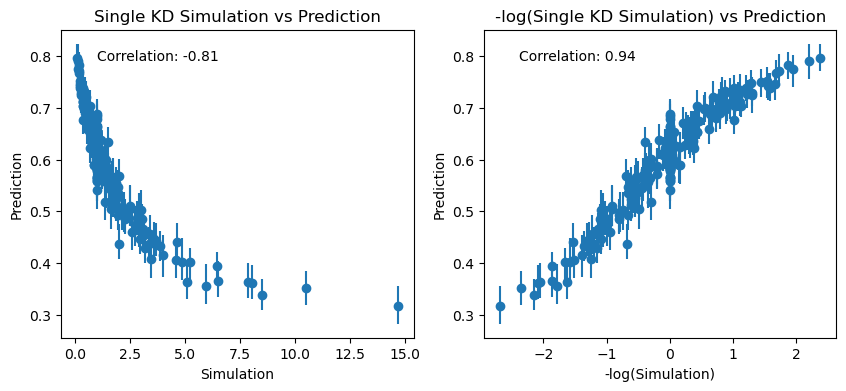

In [32]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#scatter plot single_kd_sim vs single_kd_pred_means
ax1.scatter(single_kd_sim, single_prob_pred_means)
# add bars for 95% confidence interval
ax1.vlines(single_kd_sim, single_prob_pred_conf[:, 0], single_prob_pred_conf[:, 1])
ax1.set_title('Single KD Simulation vs Prediction')
ax1.set_xlabel('Simulation')
ax1.set_ylabel('Prediction')
# add correlation coefficient to plot
ax1.text(0.1, 0.9, f'Correlation: {np.corrcoef(single_kd_sim, single_prob_pred_means)[0, 1]:.2f}', transform=ax1.transAxes)

#scatter plot -log(single_kd_sim) vs single_kd_pred_means
ax2.scatter(-np.log(single_kd_sim), single_prob_pred_means)
# add bars for 95% confidence interval
ax2.vlines(-np.log(single_kd_sim), single_prob_pred_conf[:, 0], single_prob_pred_conf[:, 1])
ax2.set_title('-log(Single KD Simulation) vs Prediction')
ax2.set_xlabel('-log(Simulation)')
ax2.set_ylabel('Prediction')
# add correlation coefficient to plot
ax2.text(0.1, 0.9, f'Correlation: {np.corrcoef(-np.log(single_kd_sim), single_prob_pred_means)[0, 1]:.2f}', transform=ax2.transAxes)

In [16]:
# read in kd values
single_kd_sim = np.loadtxt(simulation_path+'/secondFromProt1/prot1/single_kds.txt')
#predict kds
single_kd_pred = MIMENet.inferSingleKds(model, input_size)

100%|██████████| 100/100 [00:00<00:00, 349.75it/s]


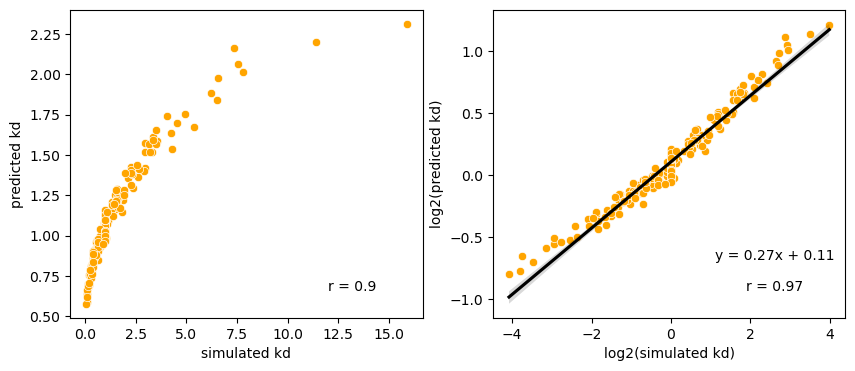

In [17]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot single_kd_sim vs single_kd_pred
sns.scatterplot(x=single_kd_sim, y=single_kd_pred, color='orange', ax=ax1)
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted kd')
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(single_kd_sim, single_kd_pred)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)

# log2(single_kd_sim) vs log2(single_kd_pred)
sns.scatterplot(x=np.log2(single_kd_sim), y=np.log2(single_kd_pred), color='orange', ax=ax2)
ax2.set_xlabel('log2(simulated kd)')
ax2.set_ylabel('log2(predicted kd)')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(np.log2(single_kd_sim), np.log2(single_kd_pred))[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)
#show line of best fit
sns.regplot(x=np.log2(single_kd_sim), y=np.log2(single_kd_pred), color='black', scatter=False, ax=ax2)
# show equation of line of best fit
plt.text(0.8, 0.2, 'y = '+str(np.round(np.polyfit(np.log2(single_kd_sim), np.log2(single_kd_pred), 1)[0], 2))+'x + '+str(np.round(np.polyfit(np.log2(single_kd_sim), np.log2(single_kd_pred), 1)[1], 2)), ha='center', va='center', transform=plt.gca().transAxes)
plt.show()


In [18]:
#load pairwise kd values
pair_kd_sim = np.loadtxt(simulation_path+'/secondFromProt1/prot1/pairwise_kds.txt')

#predict pairwise probabilities
pair_prob_pred = MIMENet.inferPairwiseProbabilities(model, input_size)

#predict pairwise kds
pair_kd_pred = MIMENet.inferPairwiseKds(model, input_size)

100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


Text(0.8, 0.1, 'r = 0.97')

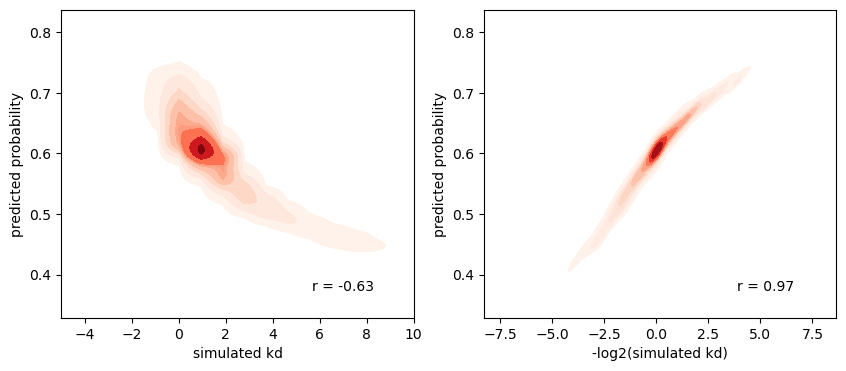

In [19]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot pair_kd_sim vs pair_kd_pred as kde plot
sns.kdeplot(x=pair_kd_sim, y=pair_prob_pred, cmap='Reds', fill=True, ax=ax1)
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted probability')
#set x limit
ax1.set_xlim(-5, 10)
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_kd_sim, pair_prob_pred)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot log2(pair_kd_sim) vs log2(pair_kd_pred) as kde plot
sns.kdeplot(x=-np.log2(pair_kd_sim), y=pair_prob_pred, cmap='Reds', fill=True, ax=ax2)
ax2.set_xlabel('-log2(simulated kd)')
ax2.set_ylabel('predicted probability')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(-np.log2(pair_kd_sim), pair_prob_pred)[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)

Text(0.8, 0.1, 'r = 0.97')

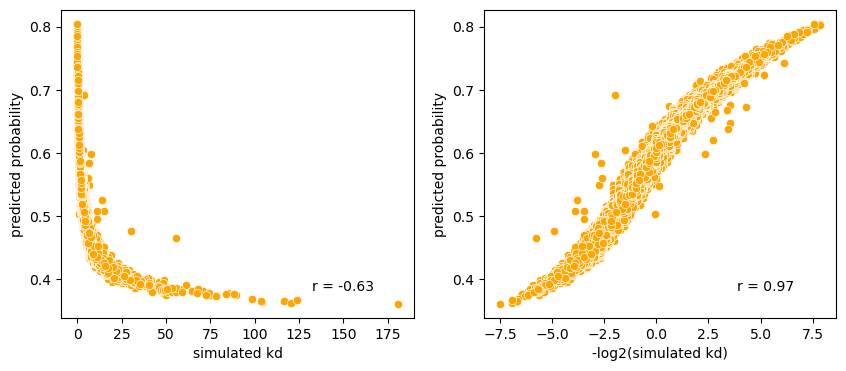

In [20]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot pair_kd_sim vs pair_prob_pred as scatter plot
sns.scatterplot(x=pair_kd_sim, y=pair_prob_pred, color='orange', ax=ax1)
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted probability')
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_kd_sim, pair_prob_pred)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot -log2(pair_kd_sim) vs pair_prob_pred as scatter plot
sns.scatterplot(x=-np.log2(pair_kd_sim), y=pair_prob_pred, color='orange', ax=ax2)
ax2.set_xlabel('-log2(simulated kd)')
ax2.set_ylabel('predicted probability')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(-np.log2(pair_kd_sim), pair_prob_pred)[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)

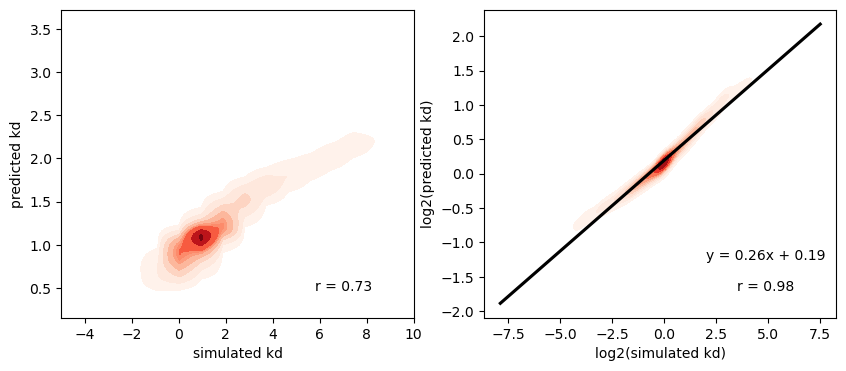

In [21]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot pair_kd_sim vs pair_kd_pred as kde plot
sns.kdeplot(x=pair_kd_sim, y=pair_kd_pred, cmap='Reds', fill=True, ax=ax1)
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted kd')
#set x limit
ax1.set_xlim(-5, 10)
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_kd_sim, pair_kd_pred)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot log2(pair_kd_sim) vs log2(pair_kd_pred) as kde plot
sns.kdeplot(x=np.log2(pair_kd_sim), y=np.log2(pair_kd_pred), cmap='Reds', fill=True, ax=ax2)
ax2.set_xlabel('log2(simulated kd)')
ax2.set_ylabel('log2(predicted kd)')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(np.log2(pair_kd_sim), np.log2(pair_kd_pred))[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)
#show line of best fit
sns.regplot(x=np.log2(pair_kd_sim), y=np.log2(pair_kd_pred), color='black', scatter=False, ax=ax2)
# show equation of line of best fit
plt.text(0.8, 0.2, 'y = '+str(np.round(np.polyfit(np.log2(pair_kd_sim), np.log2(pair_kd_pred), 1)[0], 2))+'x + '+str(np.round(np.polyfit(np.log2(pair_kd_sim), np.log2(pair_kd_pred), 1)[1], 2)), ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

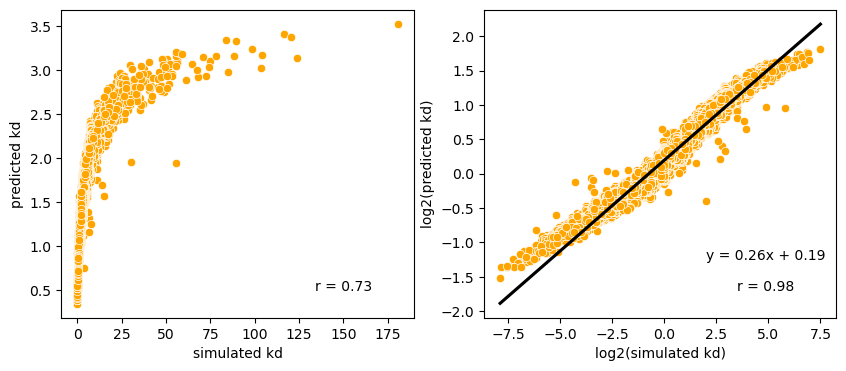

In [22]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot pair_kd_sim vs pair_kd_pred as scatter plot
sns.scatterplot(x=pair_kd_sim, y=pair_kd_pred, color='orange', ax=ax1)
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted kd')
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_kd_sim, pair_kd_pred)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot log2(pair_kd_sim) vs log2(pair_kd_pred) as scatter plot
sns.scatterplot(x=np.log2(pair_kd_sim), y=np.log2(pair_kd_pred), color='orange', ax=ax2)
ax2.set_xlabel('log2(simulated kd)')
ax2.set_ylabel('log2(predicted kd)')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(np.log2(pair_kd_sim), np.log2(pair_kd_pred))[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)
#show line of best fit
sns.regplot(x=np.log2(pair_kd_sim), y=np.log2(pair_kd_pred), color='black', scatter=False, ax=ax2)
# show equation of line of best fit
plt.text(0.8, 0.2, 'y = '+str(np.round(np.polyfit(np.log2(pair_kd_sim), np.log2(pair_kd_pred), 1)[0], 2))+'x + '+str(np.round(np.polyfit(np.log2(pair_kd_sim), np.log2(pair_kd_pred), 1)[1], 2)), ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

In [23]:
#load pairwise epistasis values
pair_epistasis_sim = np.loadtxt(simulation_path+'/secondFromProt1/prot1/pairwise_epistasis.txt')

#predict pairwise epistasis
pair_epistasis_pred = MIMENet.inferEpistasis(model, input_size)

100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


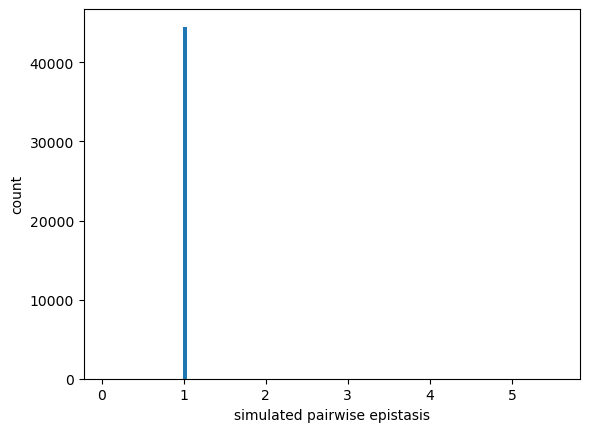

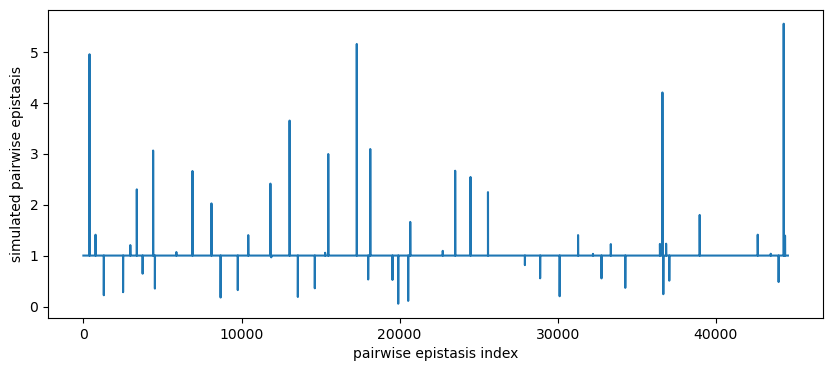

number of non 1 entries in pairwise epistasis simulation: 52


In [36]:
# exploratory analysis of pairwise epistasis simulation
# plot histogram of pairwise epistasis values
plt.hist(pair_epistasis_sim, bins=100)
plt.xlabel('simulated pairwise epistasis')
plt.ylabel('count')
plt.show()

# line plot of pairwise epistasis simulation
plt.figure(figsize=(10, 4))
plt.plot(pair_epistasis_sim)
plt.xlabel('pairwise epistasis index')
plt.ylabel('simulated pairwise epistasis')
plt.show()

# get number of non 1 entries in pairwise epistasis simulation
print('number of non 1 entries in pairwise epistasis simulation: '+str(np.sum(pair_epistasis_sim != 1)))
# fig size


Text(0.8, 0.1, 'r = -0.0')

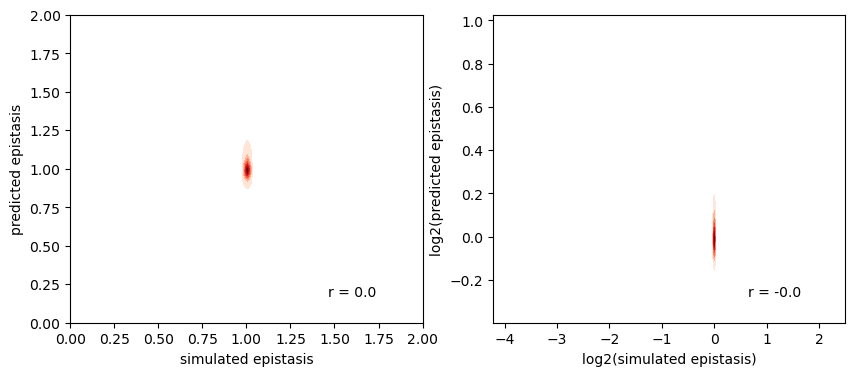

In [25]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot pair_epistasis_sim vs pair_epistasis_pred as kde plot
sns.kdeplot(x=pair_epistasis_sim, y=pair_epistasis_pred, cmap='Reds', fill=True, ax=ax1)
ax1.set_xlabel('simulated epistasis')
ax1.set_ylabel('predicted epistasis')
#set x limit
ax1.set_xlim(0, 2)
#set y limit
ax1.set_ylim(0, 2)
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_epistasis_sim, pair_epistasis_pred)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot log2(pair_epistasis_sim) vs log2(pair_epistasis_pred) as kde plot
sns.kdeplot(x=np.log2(pair_epistasis_sim), y=np.log2(pair_epistasis_pred), cmap='Reds', fill=True, ax=ax2)
ax2.set_xlabel('log2(simulated epistasis)')
ax2.set_ylabel('log2(predicted epistasis)')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(np.log2(pair_epistasis_sim), np.log2(pair_epistasis_pred))[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)

Text(0.8, 0.1, 'r = -0.0')

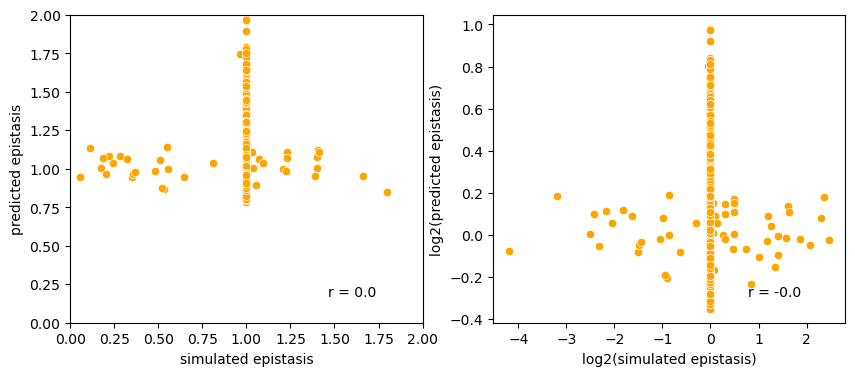

In [26]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# plot pair_epistasis_sim vs pair_epistasis_pred as scatter plot
sns.scatterplot(x=pair_epistasis_sim, y=pair_epistasis_pred, color='orange', ax=ax1)
ax1.set_xlabel('simulated epistasis')
ax1.set_ylabel('predicted epistasis')
#set x limit
ax1.set_xlim(0, 2)
#set y limit
ax1.set_ylim(0, 2)
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_epistasis_sim, pair_epistasis_pred)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot log2(pair_epistasis_sim) vs log2(pair_epistasis_pred) as scatter plot
sns.scatterplot(x=np.log2(pair_epistasis_sim), y=np.log2(pair_epistasis_pred), color='orange', ax=ax2)
ax2.set_xlabel('log2(simulated epistasis)')
ax2.set_ylabel('log2(predicted epistasis)')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(np.log2(pair_epistasis_sim), np.log2(pair_epistasis_pred))[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)

In [27]:
model, history = MIMENet.train(
    training_path=training_path+'dm_parsed_reads.txt',
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    lambda_l1=lambda_l1,
    hidden_size_factor=hidden_size_factor,
    bottleneck=bottleneck,
    kd_path="../data/simulation_data/experimental_conditions/secondFromProt1/prot1/single_kds.txt",
    model_path='./modelExpCond.pth'
)

Device: cuda:0
Number of training examples: 2147629


100%|██████████| 30/30 [54:19<00:00, 108.64s/it]


In [28]:
#save model
torch.save(model.state_dict(), './modelExpCond2.pth')
#save training history as json
with open('./history_exp2.json', 'w') as f:
    json.dump(history, f)

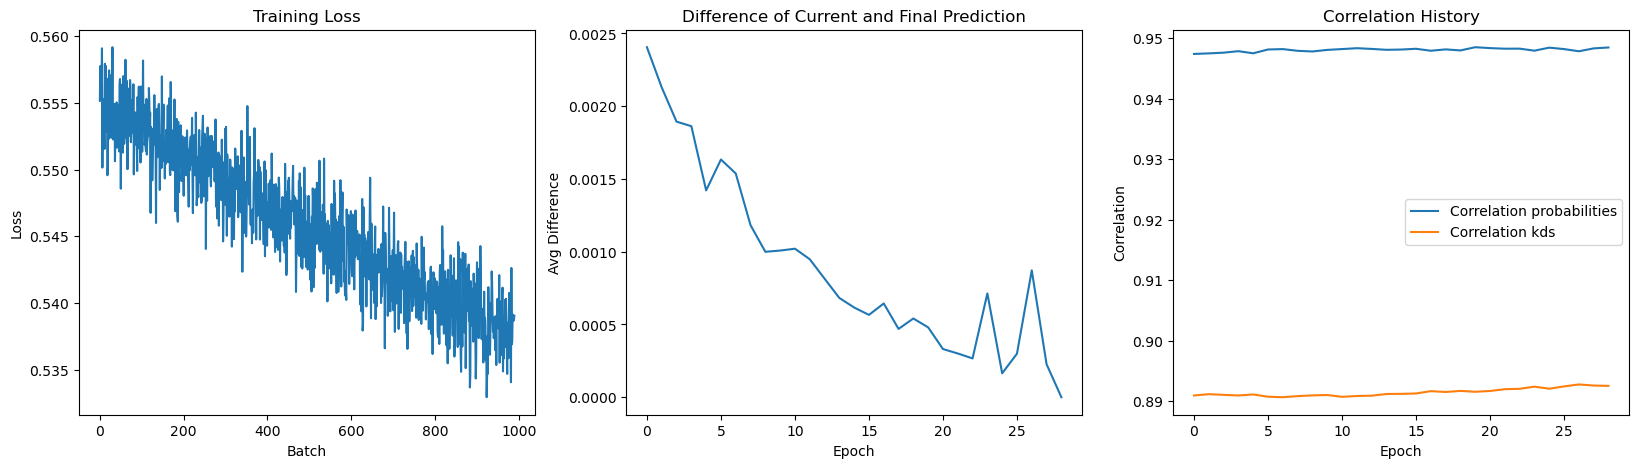

In [29]:
# set up 3 side by side plots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

#plot training history
axs[0].plot(history['training'])
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')

#plot difference of current and final prediction

#initialize difference array
predictions = np.array(history['prediction'][1:])
difference = np.zeros((predictions.shape[0], predictions.shape[1]))
#calculate difference
for i in range(predictions.shape[0]):
    difference[i] = np.abs(predictions[i] - predictions[-1])
#average over columns
difference = np.mean(difference, axis=1)
#plot difference
axs[1].plot(difference)
axs[1].set_title('Difference of Current and Final Prediction')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Avg Difference')

#plot correlation history rows as lines
axs[2].plot(history['correlation_probs'][1:], label='Correlation probabilities')
axs[2].plot(history['correlation_kds'][1:], label='Correlation kds')
axs[2].legend()
axs[2].set_title("Correlation History")
axs[2].set_ylabel("Correlation")
axs[2].set_xlabel("Epoch")
plt.show()

In [30]:
#load pairwise kd values
pair_kd_sim = np.loadtxt(simulation_path+'/secondFromProt1/prot1/pairwise_kds.txt')

#predict pairwise probabilities
pair_prob_pred = MIMENet.inferPairwiseProbabilities(model, input_size)

#predict pairwise kds
pair_kd_pred = MIMENet.inferPairwiseKds(model, input_size)

100%|██████████| 100/100 [00:36<00:00,  2.70it/s]


Text(0.8, 0.1, 'r = 0.97')

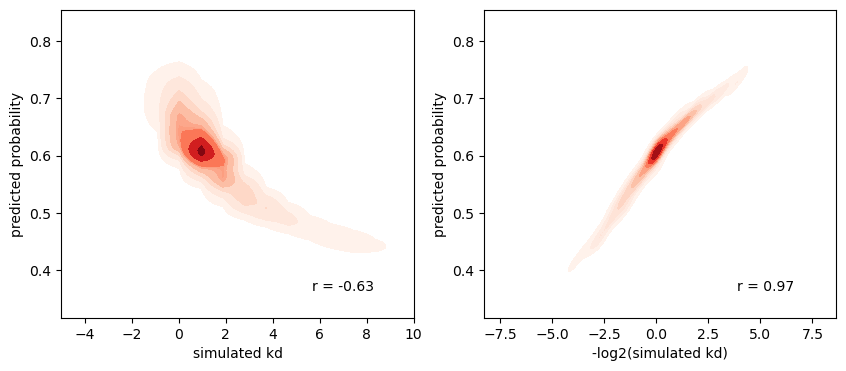

In [31]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot pair_kd_sim vs pair_kd_pred as kde plot
sns.kdeplot(x=pair_kd_sim, y=pair_prob_pred, cmap='Reds', fill=True, ax=ax1)
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted probability')
#set x limit
ax1.set_xlim(-5, 10)
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_kd_sim, pair_prob_pred)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot log2(pair_kd_sim) vs log2(pair_kd_pred) as kde plot
sns.kdeplot(x=-np.log2(pair_kd_sim), y=pair_prob_pred, cmap='Reds', fill=True, ax=ax2)
ax2.set_xlabel('-log2(simulated kd)')
ax2.set_ylabel('predicted probability')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(-np.log2(pair_kd_sim), pair_prob_pred)[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)

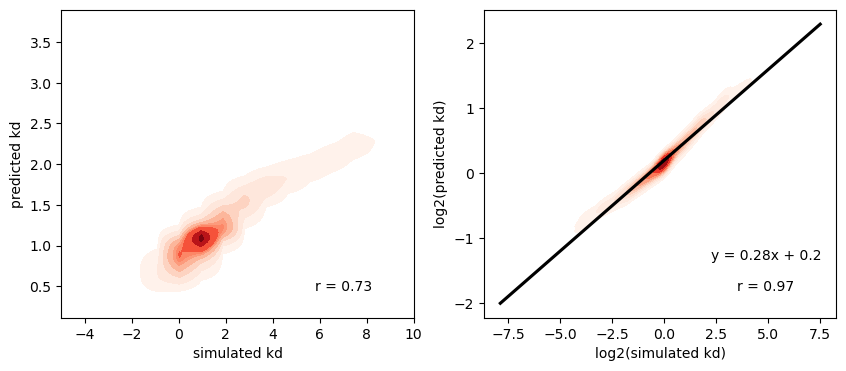

In [32]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot pair_kd_sim vs pair_kd_pred as kde plot
sns.kdeplot(x=pair_kd_sim, y=pair_kd_pred, cmap='Reds', fill=True, ax=ax1)
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted kd')
#set x limit
ax1.set_xlim(-5, 10)
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_kd_sim, pair_kd_pred)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot log2(pair_kd_sim) vs log2(pair_kd_pred) as kde plot
sns.kdeplot(x=np.log2(pair_kd_sim), y=np.log2(pair_kd_pred), cmap='Reds', fill=True, ax=ax2)
ax2.set_xlabel('log2(simulated kd)')
ax2.set_ylabel('log2(predicted kd)')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(np.log2(pair_kd_sim), np.log2(pair_kd_pred))[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)
#show line of best fit
sns.regplot(x=np.log2(pair_kd_sim), y=np.log2(pair_kd_pred), color='black', scatter=False, ax=ax2)
# show equation of line of best fit
plt.text(0.8, 0.2, 'y = '+str(np.round(np.polyfit(np.log2(pair_kd_sim), np.log2(pair_kd_pred), 1)[0], 2))+'x + '+str(np.round(np.polyfit(np.log2(pair_kd_sim), np.log2(pair_kd_pred), 1)[1], 2)), ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

In [33]:
#load pairwise epistasis values
pair_epistasis_sim = np.loadtxt(simulation_path+'/secondFromProt1/prot1/pairwise_epistasis.txt')

#predict pairwise epistasis
pair_epistasis_pred = MIMENet.inferEpistasis(model, input_size)

100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


Text(0.8, 0.1, 'r = -0.0')

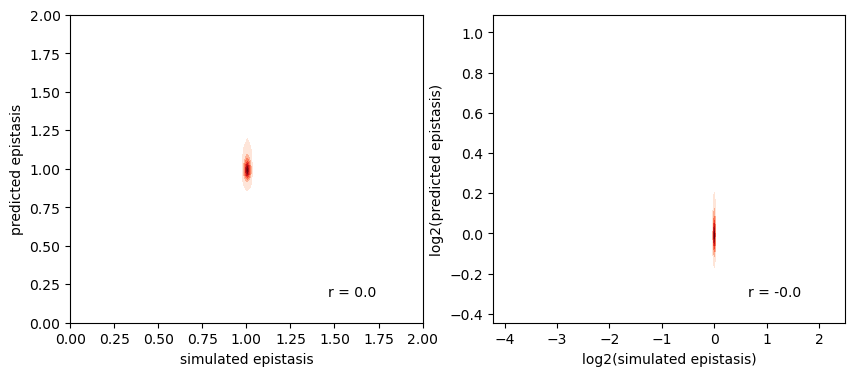

In [34]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot pair_epistasis_sim vs pair_epistasis_pred as kde plot
sns.kdeplot(x=pair_epistasis_sim, y=pair_epistasis_pred, cmap='Reds', fill=True, ax=ax1)
ax1.set_xlabel('simulated epistasis')
ax1.set_ylabel('predicted epistasis')
#set x limit
ax1.set_xlim(0, 2)
#set y limit
ax1.set_ylim(0, 2)
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_epistasis_sim, pair_epistasis_pred)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot log2(pair_epistasis_sim) vs log2(pair_epistasis_pred) as kde plot
sns.kdeplot(x=np.log2(pair_epistasis_sim), y=np.log2(pair_epistasis_pred), cmap='Reds', fill=True, ax=ax2)
ax2.set_xlabel('log2(simulated epistasis)')
ax2.set_ylabel('log2(predicted epistasis)')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(np.log2(pair_epistasis_sim), np.log2(pair_epistasis_pred))[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)